# Analysis Notebook
1. Setup
2. Set up directory
3. Load logging file
4. Reverse-engineer dictionary
5. Plot
5a) Loss
5b) Train Accuracy
5c) Test Accuracy

# 1 - Setup

In [1]:
import matplotlib.pyplot as plt
import itertools
import copy
import warnings
import json
import numpy as np
import os
import math
import torch
%load_ext autoreload
%autoreload 2

# 2- Set up directory

In [2]:
# Load logging file

# when you called jupyter from ParlAI/:
path = '../data/models/convai2/'
folder = 'profilememory'
session_directory = os.path.join(path, folder)

#print(session_directory)
#for root, dirs, files in os.walk(session_directory):
    #for name in files:
    #    print(os.path.join(root, name))
    #for name in dirs:
    #    print(os.path.join(root, name))
    #print(root)
    #print(dirs)
    #print(files)

# 3 - Load Data

In [3]:
#results = {}
#loggings = 

file = "logging/log.txt"

with open ((path + folder + "/" + file), 'rt') as in_file:  # Open file lorem.txt for reading of text data.
    log = in_file.read()# Read the entire file into a variable named contents.
    print(log) # Print contents.

[ optional arguments: ] 
[  task: convai2:self ]
[  pytorch_teacher_task: None ]
[  pytorch_teacher_dataset: None ]
[  download_path: /home/team_roboy/ss18_showmaster/ParlAI/downloads ]
[  datatype: train ]
[  image_mode: raw ]
[  numthreads: 1 ]
[  hide_labels: False ]
[  batchsize: 64 ]
[  batch_sort: True ]
[  context_length: -1 ]
[  include_labels: True ]
[  pytorch_datafile:  ]
[  numworkers: 4 ]
[  pytorch_preprocess: False ]
[  batch_sort_cache: none ]
[  batch_length_range: 5 ]
[  datapath: /home/team_roboy/ss18_showmaster/ParlAI/data ]
[  model: projects.personachat.persona_seq2seq:PersonachatSeqseqAgentSplit ]
[  model_file: /tmp/roboy_profilemem ]
[  dict_class: None ]
[  evaltask: None ]
[  display_examples: False ]
[  num_epochs: -1 ]
[  max_train_time: -1 ]
[  validation_every_n_secs: 900.0 ]
[  save_every_n_secs: -1 ]
[  save_after_valid: False ]
[  validation_every_n_epochs: -1 ]
[  validation_max_exs: -1 ]
[  validation_patience: 25 ]
[  validation_metric: f1 ]
[  vali

# 4 - Create Dictionary

In [4]:
# reverse engineer logged shell output from string to dictionary
log_dict = dict()
time_between_validations = 900
time_for_validations = 270

# needed to extract relevant entreis form string
def find_between( s, first, last ):
    try:
        start = s.index( first ) + len( first )
        end = s.index( last, start )
        return s[start:end]
    except ValueError:
        return ""


with open ((path + folder + "/" + file), 'rt') as fp: 
    line = fp.readline()
    cnt = 1
    dict_cnt = 1
    val_time = time_between_validations
    while line:
        teststring = line.strip()
        
        # filter for relevant lines
        if (teststring[0:7] == '[ time:') == True:
            
            # extract relevant entries form string
            time = float(find_between( teststring, "time:", "s " ))   
            total_exs = float(find_between( teststring, "total_exs:", " " ))
            #time_left = float(find_between( teststring, "time_left:", "s " ))
            
            exs = float(find_between( teststring, "'exs': ", ", " ))
            #mean_rank = float(find_between( teststring, "'mean_rank':", ", " ))
            accuracy = float(find_between( teststring, "'accuracy': ", ", " ))
            try:
                train_f1 = float(find_between( teststring, "'f1': ", ", " ))
            except:
                train_f1 = float(find_between( teststring, "'f1': ", "}" ))
            try:
                train_loss = float(find_between( teststring, "'loss': ", ", " ))
            except: 
                train_loss = None
            try:
                train_ppl = float(find_between( teststring, "'ppl': ", "}" ))
            except:
                train_ppl = None
            
            #total = float(find_between( teststring, "'total': ", ", 'accuracy':" ))
            #accuracy = float(find_between( teststring, "'accuracy': ", ", 'f1':" ))
            #f1 = float(find_between( teststring, "'f1': ", ", 'loss'" ))
            #loss = float(find_between( teststring, "'loss': ", ", 'ppl'" ))
            #ppl = float(find_between( teststring, "'ppl': ", "}" ))                  
            
            #save to dictionary
            log_dict[dict_cnt] = {'time': time, 'total_exs': total_exs, 'exs': exs, \
                                  'train_accuracy': accuracy, 'val_accuracy': None, \
                                  'train_f1': train_f1, 'val_f1:': None,\
                                  'train_loss': train_loss, 'val_loss': None, \
                                  'hits@1': None, 'hits@5': None, 'hits@10': None, 'hits@100': None,\
                                  'train_ppl': train_ppl}

            #{'time': time, 'parleys': parleys, 'time_left': time_left,'total': total, 'mean_rank': mean_rank, 'loss': loss}
            dict_cnt += 1
        
        # log validations every x seconds
        elif (teststring[0:7] == 'valid:{') == True:
            exs = float(find_between( teststring, "'exs': ", ", " ))
            accuracy = float(find_between( teststring, "'accuracy': ", ", " ))
            val_f1 = float(find_between( teststring, "'f1': ", ", " ))
            hits1 = float(find_between( teststring, "'hits@1': ", ", " ))
            hits5 = float(find_between( teststring, "'hits@5': ", ", " ))
            hits10 = float(find_between( teststring, "'hits@10': ", ", " ))
            hits100 = float(find_between( teststring, "'hits@100': ", ", " ))
            val_loss = float(find_between( teststring, "'loss': ", ", " ))
            val_ppl = float(find_between( teststring, "'ppl': ", "}" ))
            log_dict[dict_cnt] = {'time': val_time, 'total_exs': None, 'exs': exs, 
                                  'train_accuracy': None, 'val_accuracy': accuracy, \
                                  'train_f1': None, 'val_f1': val_f1, \
                                  'train_loss': None, 'val_loss': val_loss, \
                                  'hits@1': hits1, 'hits@5': hits5, 'hits@10': hits10, 'hits@100': hits100, \
                                  'val_ppl': val_ppl}
            val_time += time_between_validations+time_for_validations
            dict_cnt += 1
        elif (teststring[0:43] == '[ ran out of patience! stopping training. ]') == True:
            print('Training complete!')

        
        line = fp.readline()
        cnt += 1
#print(log_dict)

Training complete!


# 5 - Plots

In [5]:
### plot parameters
#fontsizes
import matplotlib.patches as mpatches

fs_title = 24
fs_ax_labels = 20
fs_tick_labels=18
fs_legend = 20

is_final_plot = True

# 5.1 - LOSS

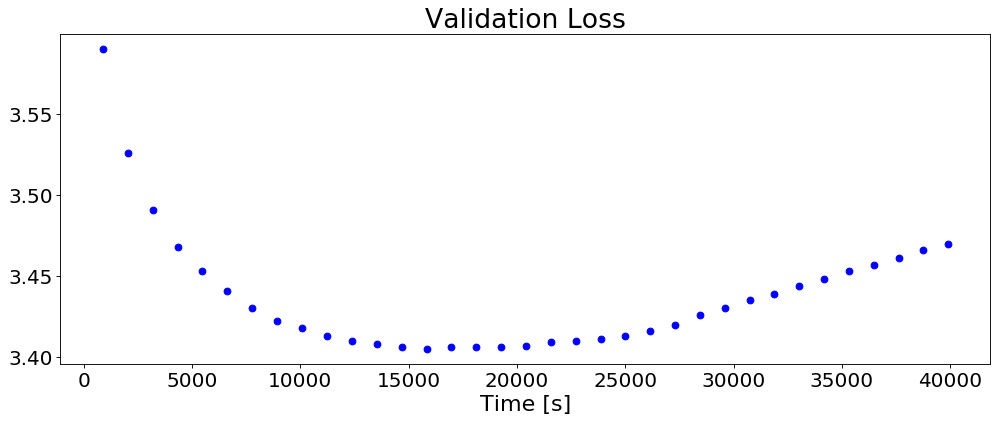

In [17]:
# Plot loss

fig_trloss=plt.figure(dpi= 80, facecolor='w', edgecolor='k')

plot = plt.subplot(2, 1, 1)
plt.title('Validation Loss',fontsize= fs_title)

for i in range(1,len(log_dict)):
    try:
        val_loss = log_dict[i]['val_loss']
        plt.plot(time, val_loss, marker = 'o', color = 'blue')
    except:
        pass
    time = log_dict[i]['time']
    #try:
    #    train_loss = log_dict[i]['train_loss']
    #    plt.plot(time, train_loss, marker = 'o', color = 'blue')
    #except:
    #    pass


plt.xlabel('Time [s]', fontsize= fs_ax_labels)

#plt.legend(loc='best', fontsize = fs_legend)
plt.gcf().set_size_inches(15, 12)
plt.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
#blue_patch = mpatches.Patch(color='blue', label='Training Loss')
#red_patch = mpatches.Patch(color='red', label='Validation Loss')
#plt.legend(handles=[red_patch]) #blue_patch, 
plt.show()

# 5.2 - Accuracy

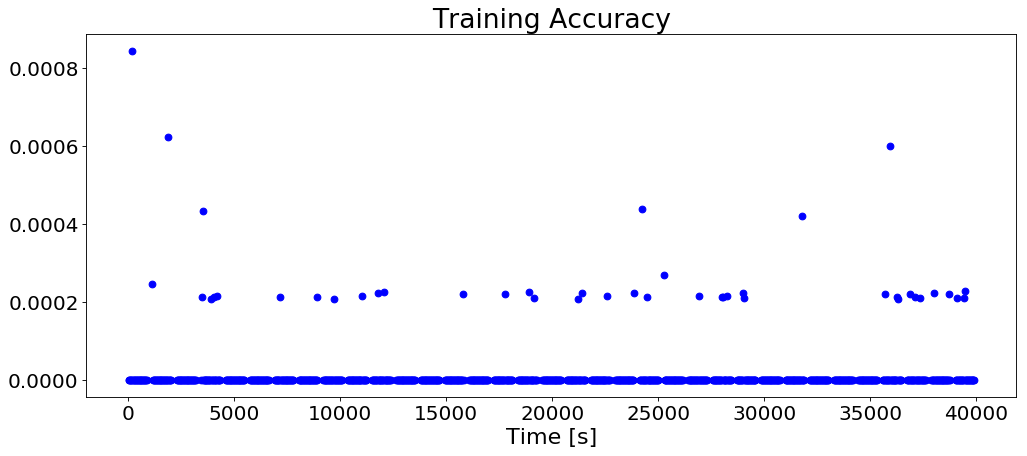

In [7]:
# Plot training accuracy

fig_tr_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_tr_acc.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('Training Accuracy', fontsize=fs_title)


for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    acc = log_dict[i]['train_accuracy']
    if acc != None:
        plt.plot(time, acc, marker = 'o', color = 'blue')

        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

# 5.3 - Hits@X

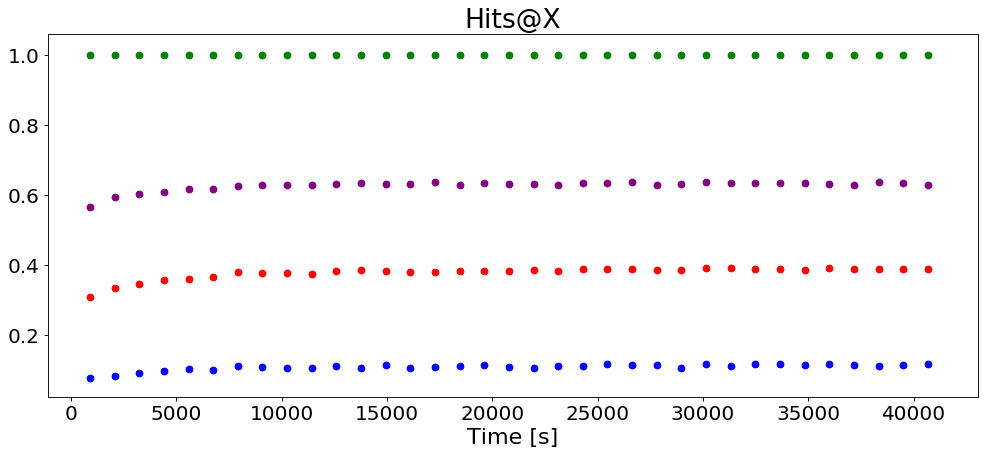

In [8]:
# Plot Hits @ X

fig_trhits=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_trhits.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('Hits@X', fontsize=fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    try:
        hits1 = log_dict[i]['hits@1']
        hits5 = log_dict[i]['hits@5']
        hits10 = log_dict[i]['hits@10']
        hits100 = log_dict[i]['hits@100']
        plt.scatter(time, hits1, marker = 'o', color = 'blue')
        plt.scatter(time, hits5, marker = 'o', color = 'red')
        plt.scatter(time, hits10, marker = 'o', color = 'purple')
        plt.scatter(time, hits100, marker = 'o', color = 'green')
    except:
        pass
        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

# 5.4 - F1

/Users/christoph/Documents/Roboy/FacebookResearch/venvFB/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


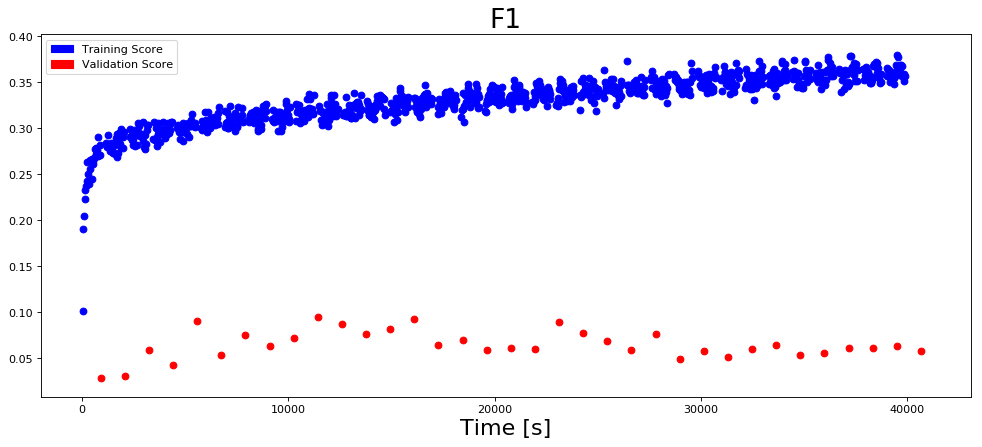

In [9]:
# Plot F1 score

fig_f1hits=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_trhits.add_subplot(111)

#plot = plt.subplot(2, 1, 1)
plt.title('F1', fontsize=fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    try:
        train_f1 = log_dict[i]['train_f1']
        plt.scatter(time, train_f1, marker = 'o', color = 'blue')
    except:
        pass
    try:
        val_f1 = log_dict[i]['val_f1']
        plt.scatter(time, val_f1, marker = 'o', color = 'red')
    except:
        pass
        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
blue_patch = mpatches.Patch(color='blue', label='Training Score')
red_patch = mpatches.Patch(color='red', label='Validation Score')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

No handles with labels found to put in legend.


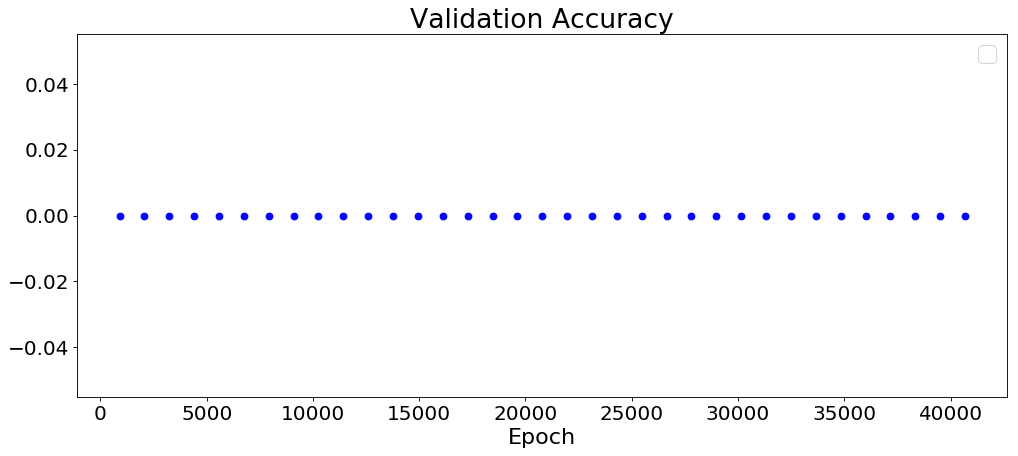

In [10]:
# Plot valdiation accuracy

fig_val_acc=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_val_acc.add_subplot(111)

plt.title('Validation Accuracy', fontsize=fs_title)


for i in range(1,len(log_dict)):
    try:
        time = log_dict[i]['time']
        acc = log_dict[i]['val_accuracy']
        if acc != None:
            plt.plot(time, acc, marker = 'o', color = 'blue')
    except:
        pass

plt.xlabel('Epoch', fontsize = fs_ax_labels)
plt.legend(loc='best', fontsize= fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
plt.show()

/Users/christoph/Documents/Roboy/FacebookResearch/venvFB/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


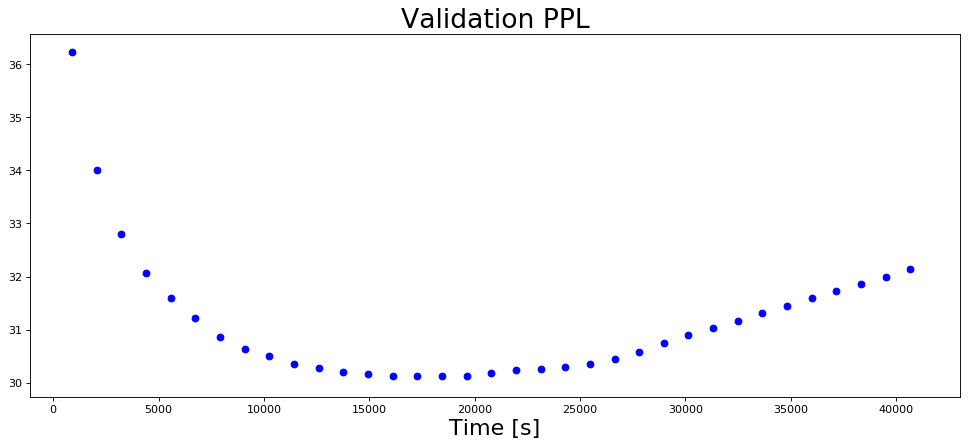

In [18]:
# Plot PPL score

fig_ppl=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_trhits.add_subplot(111)

plt.title('Validation PPL', fontsize=fs_title)

for i in range(1,len(log_dict)):
    time = log_dict[i]['time']
    #try:
    #    train_f1 = log_dict[i]['train_ppl']
    #    plt.scatter(time, train_f1, marker = 'o', color = 'blue')
    #except:
    #    pass
    try:
        val_f1 = log_dict[i]['val_ppl']
        plt.scatter(time, val_f1, marker = 'o', color = 'blue')
    except:
        pass
        
plt.xlabel('Time [s]', fontsize = fs_ax_labels)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)
#blue_patch = mpatches.Patch(color='blue', label='Training Score')
#red_patch = mpatches.Patch(color='red', label='Validation Score')
#plt.legend(handles=[blue_patch, red_patch])
plt.show()

No handles with labels found to put in legend.


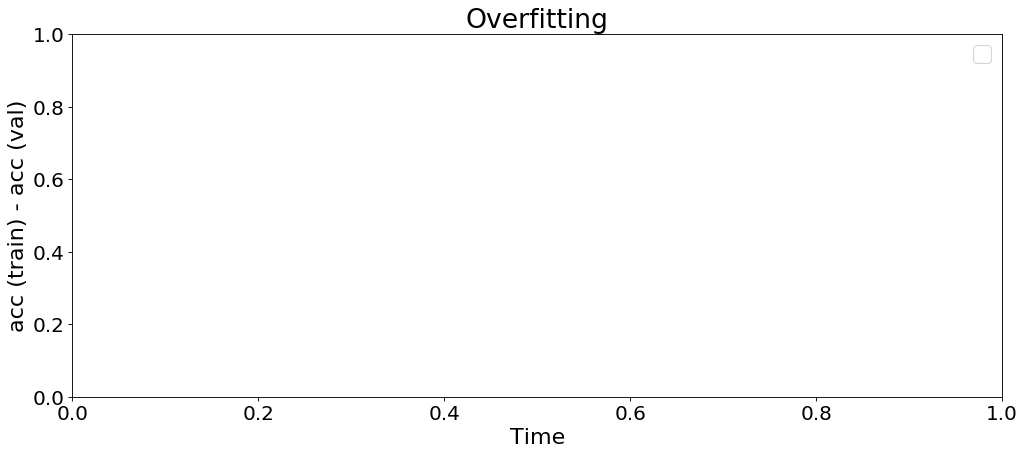

In [19]:
### Plot overfitting curves (difference between train_acc and small_val_acc)

fig_overfitting=plt.figure(dpi= 80, facecolor='w', edgecolor='k')
plot = fig_overfitting.add_subplot(111)

plt.title('Overfitting', fontsize=fs_title)

for i in range(1,len(log_dict)):
    try:
        time = log_dict[i]['time']
        overfit = abs(log_dict[i]['val_acc']-log_dict[i]['train_acc'])

        at_end = overfitting[-1]
        print("\tAverage:%.3f\tOverfitting at end:%.3f" % (average, at_end))
        plt.plot(time, acc, marker = 'o')
    except:
        pass
    
plt.xlabel('Time', fontsize=fs_ax_labels)
plt.ylabel('acc (train) - acc (val)', fontsize=fs_ax_labels)
plt.legend(loc='best', fontsize=fs_legend)
plt.gcf().set_size_inches(15, 6)
plot.tick_params(axis='both', which='major', labelsize=fs_tick_labels)

plt.show()

In [13]:
### Save graphics
savepath = '../data/models/convai2/profilememory/'
fig_trloss.savefig(savepath+'tr_loss.pdf',bbox_inches='tight', format='pdf')
fig_val_acc.savefig(savepath+'val_acc.pdf',bbox_inches='tight', format='pdf')
fig_tr_acc.savefig(savepath+'tr_acc.pdf',bbox_inches='tight', format='pdf')
fig_f1hits.savefig(savepath+'f1_hits.pdf',bbox_inches='tight', format='pdf')
fig_trhits.savefig(savepath+'Xhits.pdf',bbox_inches='tight', format='pdf')

#fig_combi_model.savefig(path+'acc_combi.pdf',bbox_inches='tight', format='pdf')

#fig_overfitting.savefig(path+'overfitting.pdf',bbox_inches='tight', format='pdf')
#fig_3acc.savefig(path+'3_accuracies.pdf',bbox_inches='tight', format='pdf')
#fig_val_matrix.savefig(path+'val_conf_matrix.pdf',bbox_inches='tight', format='pdf')
#fig_test_matrix.savefig(path+'test_conf_matrix.pdf',bbox_inches='tight', format='pdf')